Para este projeto, iremos utilizar algumas bibliotecas que serão apresentadas no decorrer.

In [1]:
from ingestor_api import GetInformation

from warnings import filterwarnings
filterwarnings('ignore')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 12,5
plt.style.use('seaborn-v0_8-whitegrid')

## 1 - Ajustes de Ambiente

Carregando os arquivos da consulta via API ao site "alphavantage.co" que disponibiliza uma API grátis para consultas de valores de ações.  
Neste caso, estamos utilizando as ações da Petroleo Brasil S.A - Petrobras (PBR).  

Paramêtros:
GetInformation(symbol,method,apikey)  
- symbol = 'PBR'   -> Simbolo da ação, pode-se ser encontrada facilmente em sites de ações.
- method = 'full'  -> Traz todo o histórico: 'compact' traz apenas 100 registros.  
- apikey = 'XXXXXXXXXX'  -> Valore precisa ser solicitado no site.

In [17]:
# Chamando a nossa consulta de API.
getinformation = GetInformation('PBR','full','XXXXXXXXXX')
df = getinformation.get_file()

In [18]:
df.tail()

,open,high,low,close,volume
data,,,,,
2024-04-24,16.960,17.000,16.720,16.81,19890428
2024-04-25,16.765,17.170,16.660,17.05,15895194
2024-04-26,16.850,17.150,16.820,17.05,20004626
2024-04-29,17.030,17.330,17.000,17.33,23234368
2024-04-30,17.050,17.205,16.855,16.97,19659233


## 2 - Análise Exploratória

Efetuar análises gráficas com o objetivo de identificar oportunidades de tratamento ou indicadores para o nosso modelo.

<Axes: xlabel='data'>

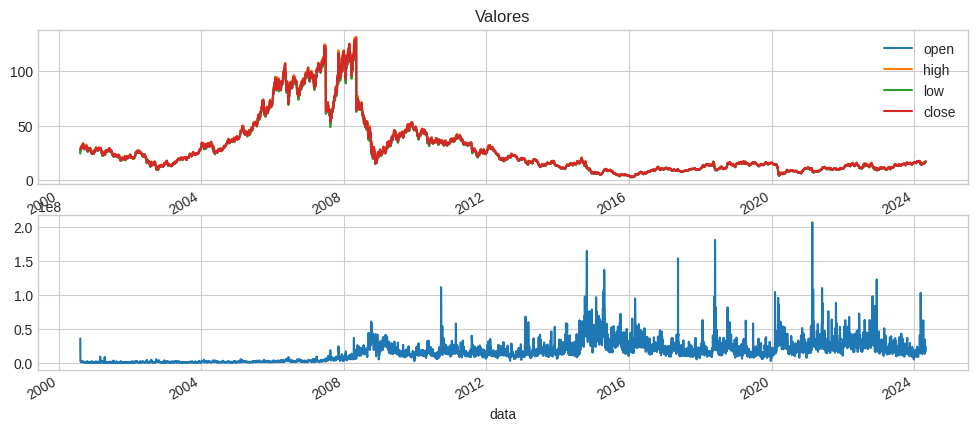

In [4]:
plt.subplot(2,1,1)
df.open.plot()
df.high.plot()
df.low.plot()
df.close.plot()
plt.title('Valores')
plt.legend()

plt.subplot(2,1,2)
df.volume.plot()

No primeiro gráfico, nota-se o aumento consideravel dos valores a partir de 2004 até 2008 e posteriormente uma quedra gradativa até um ponto de equilibro, que se manteve até os dias atuais. (Pesquisando sobre o ano de 2008 específico, encontramos notícas envidenciando o pico do valor da empresa, como a sua queda posteriormente).  

Na questão de volumes, nota-se o aumento a parir de ~2008-2010 com grande variação em menores intervalos de tempo (grande fluxo de aumento e diminuição de volume).

Vamos observar entre os anos 2007 e 2010, para entender a grande mudança que ocorreu entre esses anos. (Vamos focar apenas no valor de "close(fechamento)" valor final da ação no dia em questão.

<Axes: xlabel='data'>

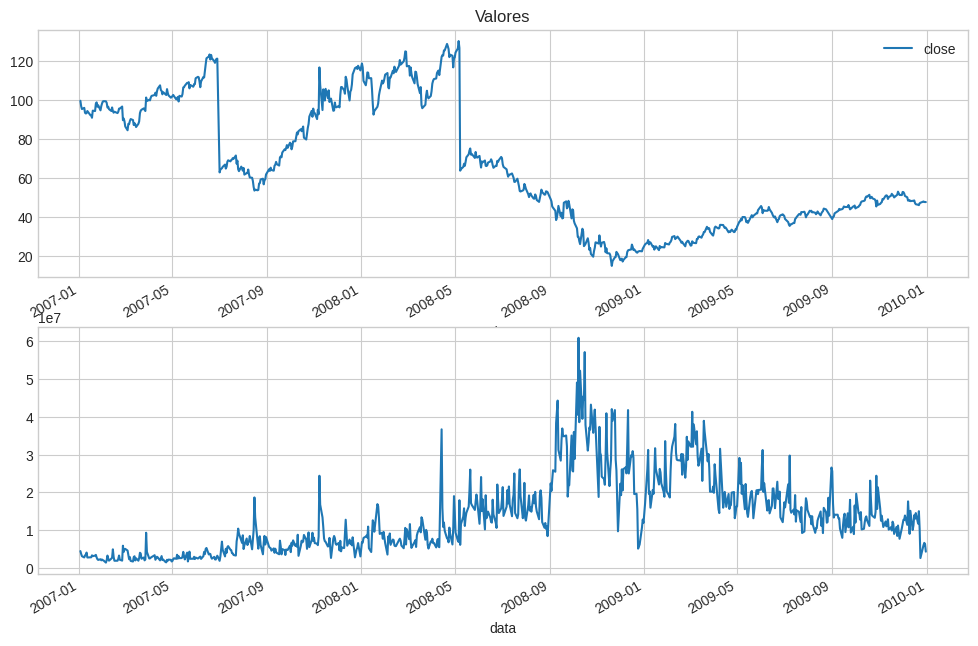

In [17]:
plt.figure(figsize = (12,8))
plt.subplot(2,1,1)
df.close.loc['2007-01-01':'2010-01-01'].plot()
plt.title('Valores')
plt.legend()

plt.subplot(2,1,2)
df.volume.loc['2007-01-01':'2010-01-01'].plot()

Pesquisando sobre os valores, encontra-se informações sobre o pico do valor da Petrobras em 2008-05 e posteriormente o seu menor valor em meados de 2009.  

Analisando o volume para a mesma época, é interessante ressaltar o aumento do volume, causado provavelmente pela queda do valor das ações. Incentivando a compra de ações com a perspectiva de recuperação da mesma.  

Podemos aqui identificar uma oportunidade de **relação** entre o valor 'close' e 'volume', já que nota-se o aumento do volume em uma baixa do valor e vice e versa.

Vamos plotar um gráfico de dispersão entre o valor e o volume, apenas para validar essa afirmação.

Text(0.5, 1.0, 'Relação FechamentoxVolume')

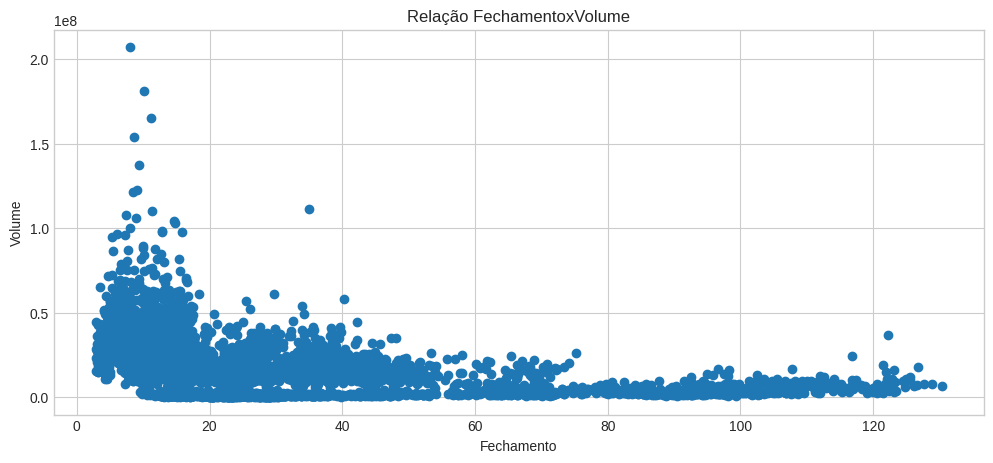

In [21]:
plt.scatter(x=df.close, y=df.volume)
plt.xlabel('Fechamento')
plt.ylabel('Volume')
plt.title('Relação FechamentoxVolume')

Outro ponto interessante é a falta de tendencia e sazonalidade em nossa série, algo já esperado quando o assunto é ações/moedas virtuais, que normalmente não apresentam essa característica;  

Abaixo, podemos extrair essas caracteristicas utilizando a biblioteca Statsmodels.

Text(0.5, 1.0, 'Residuos')

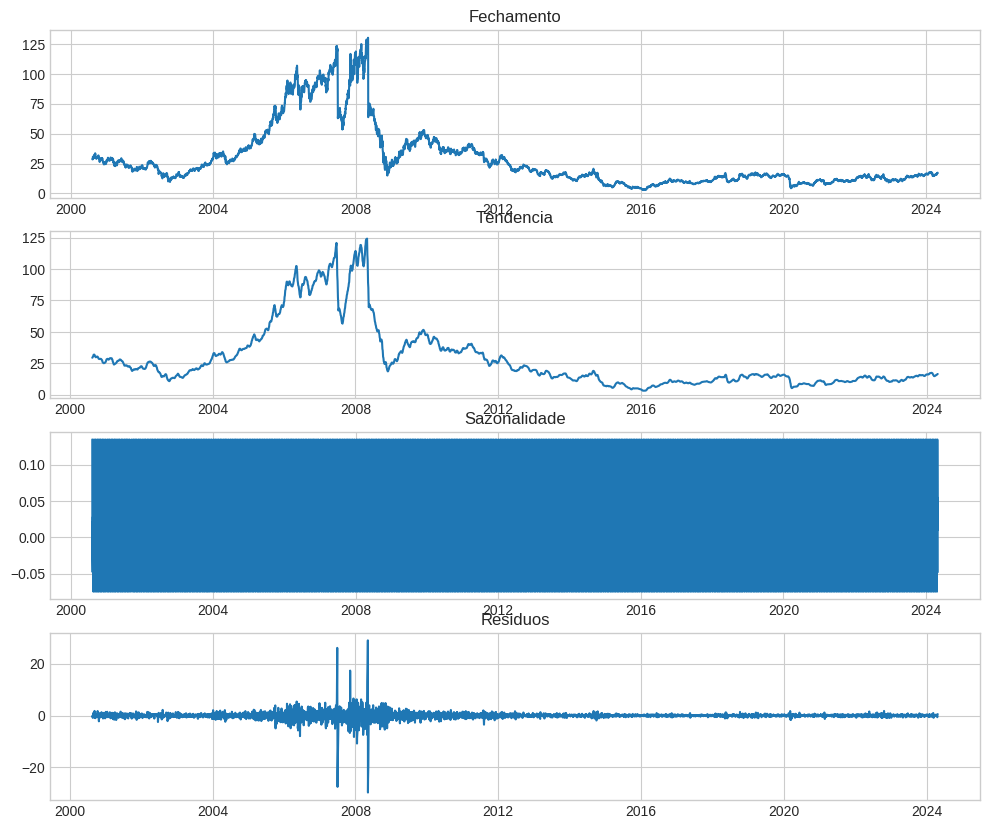

In [22]:
from statsmodels.tsa.seasonal import seasonal_decompose

result_close = seasonal_decompose(df.close, model='additive', period=12)

trend = result_close.trend
seasonal = result_close.seasonal
residual = result_close.resid

plt.figure(figsize = (12,10))
plt.subplot(4,1,1)
plt.plot(df.close)
plt.title('Fechamento')

plt.subplot(4,1,2)
plt.plot(trend)
plt.title('Têndencia')

plt.subplot(4,1,3)
plt.plot(seasonal)
plt.title('Sazonalidade')

plt.subplot(4,1,4)
plt.plot(residual)
plt.title('Residuos')

Uma outra análise que pode-ser efetuada é de autocorrelação e autocorrelação parcial, ou seja, qual é a correlação da nossa variável com o seu valor em um certo momento do passado, por exemplo, 1 ou 2 dias/meses/anos atrás? Com essa informação pode-se trabalhar o número de lags a serem utilizados na nossa modelagem.

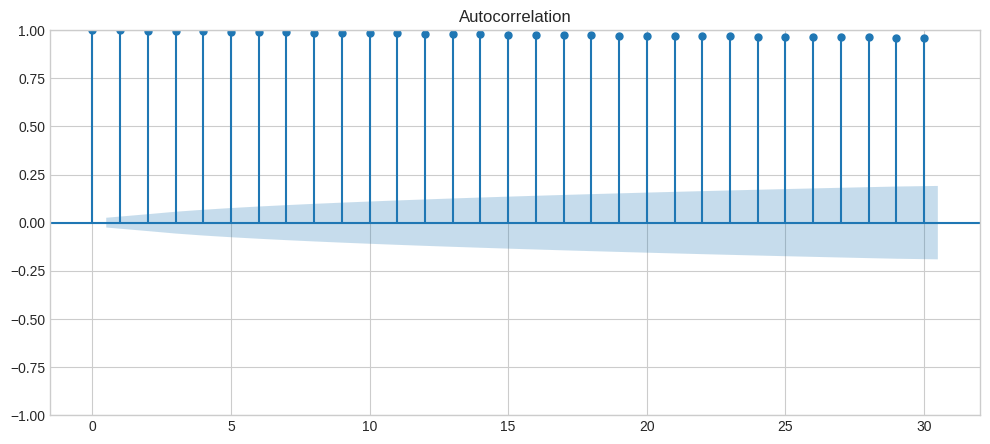

In [13]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

plot_acf(df.close, lags=30, alpha=0.05)
plt.show()

O Autocorrelação apresenta uma característica específica, ela apresenta a correlação entre os lags e não propriamente apenas do (t-1).
Com isso em mente, pode-se utilizar o Autocorrelação parcial, que apresenta apenas a correlação "pura" entre o tempo t com (t-n).

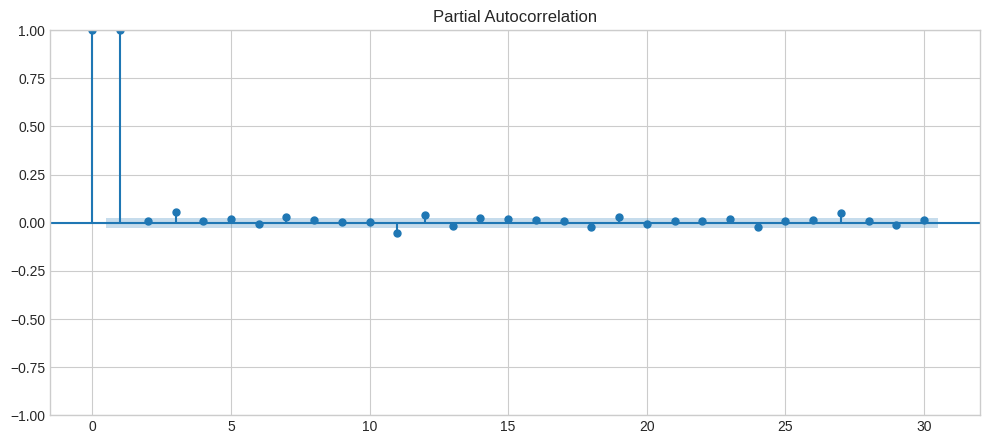

In [14]:
plot_pacf(df.close, lags=30, alpha=0.05)
plt.show()

Nota-se a auta correlação apenas até o lag=2, nos demais, temos uma correlação baixa com baixa confiança.  

Tal informação pode ser utilizada em nossa modelagem, na criação de nossas features de lag, por exemplo, sabemos que o lag=2 apresenta autacoorelação com o valor, portanto seria interessante ter essa feature em nosso modelo

## 3 - Técnicas de Ciência de Dados

Neste projeto, iremos comparar 2 modelos no treinamento e previsão dos valores desta ação, sendo eles;  
1 - Modelo Boosting: XGBRegressor  
2 - Modelo SARIMA: Statsmodels  

O modelo baseado em regressão linear, precisa ter um formato específico de dataset, sendo que o mesmo necessita de features para o seu aprendizado. Neste caso, iremos utilizar variáveis exógenas (variaveis derivadas da própria série), neste caso os lag (valor de t-1, t-2, t-n). 
Para um trabalho futuro, podemos utilizar o GridSearch para encontrar os melhores parâmetros para o modelo de regressão.  

Já o modelo ARIMA, consegue trabalhar apenas com a série temporal, portanto neste caso, iremos apenas utilizar o Auto Arima para validar o parametro "order" como o melhor disponível.

### Modelo XGBoostRegressor

In [32]:
dataset_reg = df[['close']]
dataset_reg.head(3)

,close
data,
2000-08-10,28.63
2000-08-11,28.56
2000-08-14,28.44


In [34]:
# Modelando o dataset
i = 5 #Números de lag (ou seja, 5 dias)

for x in range(i):
    dataset_reg[f'lag-{x+1}'] = dataset_reg.close.shift(x+1)

# O shift efetua o deslocamento do valor n casas, portando acaba causando valores = NaN.
dataset_reg.dropna(inplace=True)

# Podemos também, acrescentar outras variáveis em nosso dataset, como mes, trimestre e dia da semana como novas features
dataset_reg['month'] = dataset_reg.index.month
dataset_reg['quarter'] = dataset_reg.index.quarter
dataset_reg['weekday'] = dataset_reg.index.weekday

dataset_reg.head(3)

,close,lag-1,lag-2,lag-3,lag-4,lag-5,month,quarter,weekday
data,,,,,,,,,
2000-08-24,29.50,30.13,29.44,29.13,29.00,30.75,8,3,3
2000-08-25,30.25,29.50,30.13,29.44,29.13,29.00,8,3,4
2000-08-28,30.13,30.25,29.50,30.13,29.44,29.13,8,3,0


Sabemos que o numero de lag está diretamente ligado a eficiência do modelo, portanto, podemos variar esse número para testar.  
Inicialmente, iremos utilizar 5.  

Próximo passo, é a preparação dos dados de treinamento e teste. Neste estudo, iremos utilizar 75% da base para treino e 25% para Teste

Text(0.5, 1.0, 'Datasets')

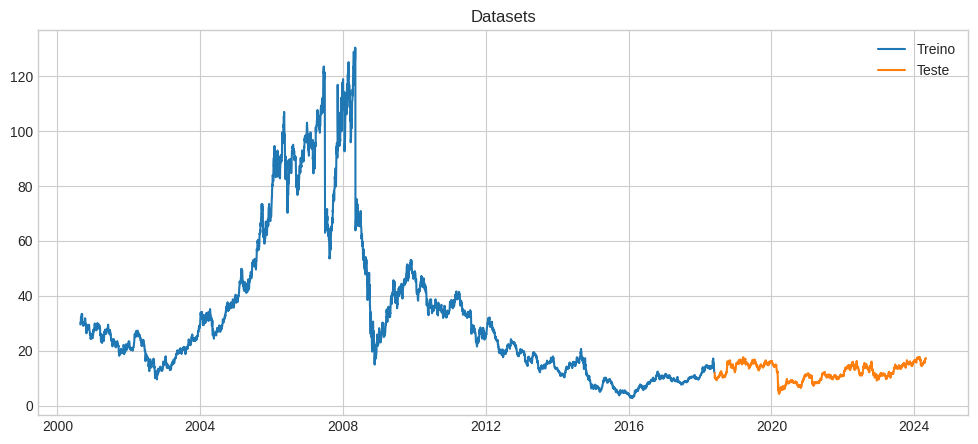

In [67]:
# Divisão entre Variáveis dependente e Independente
X = dataset_reg.drop('close', axis=1)
y = dataset_reg['close']

train_size = int(len(dataset_reg) * 3/4) # 75% da base

X_train = X[:train_size]
X_test = X[train_size:]

y_train = y[:train_size]
y_test = y[train_size:]

# Podemos observar essas separação
plt.plot(X_train.index, y_train, label='Treino')
plt.plot(X_test.index, y_test, label='Teste')
plt.legend()
plt.title('Datasets')

Primeiro, iremos treinar, testar e analisar os resultados sem hiperparametros.

Text(0.5, 1.0, 'Resultados sem Hiperparametros')

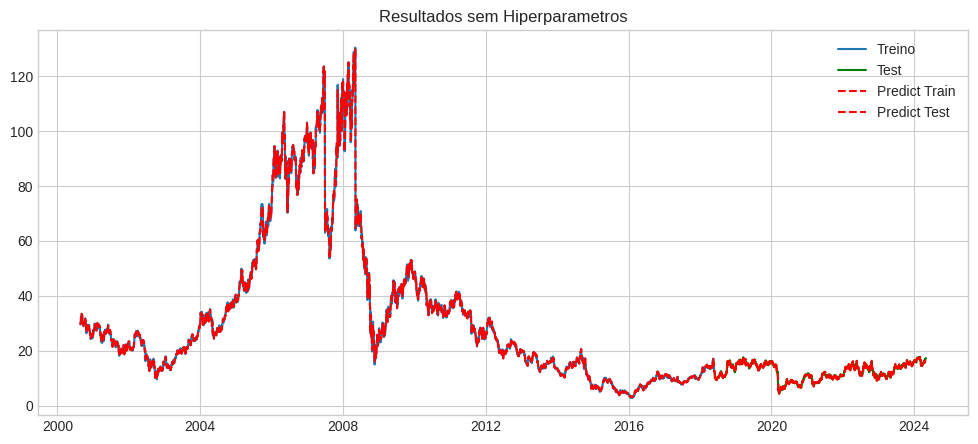

In [74]:
import xgboost as xgb

xgb = xgb.XGBRegressor()
xgb.fit(X_train, y_train)

y_predict_train = xgb.predict(X_train)
y_predict_test = xgb.predict(X_test)

# Vamos plotar os resultados de treinamento e teste
plt.plot(X_train.index, y_train, label='Treino')
plt.plot(X_test.index, y_test, label='Test', color='green')
plt.plot(X_train.index, y_predict_train, label='Predict Train', color='red', linestyle='--')
plt.plot(X_test.index, y_predict_test, label='Predict Test', color='red', linestyle='--')
plt.legend()
plt.title('Resultados sem Hiperparametros')

Vamos observar só o período de teste, para facilitar a leitura dos resultados

Text(0.5, 1.0, 'Resultados sem Hiperparametros')

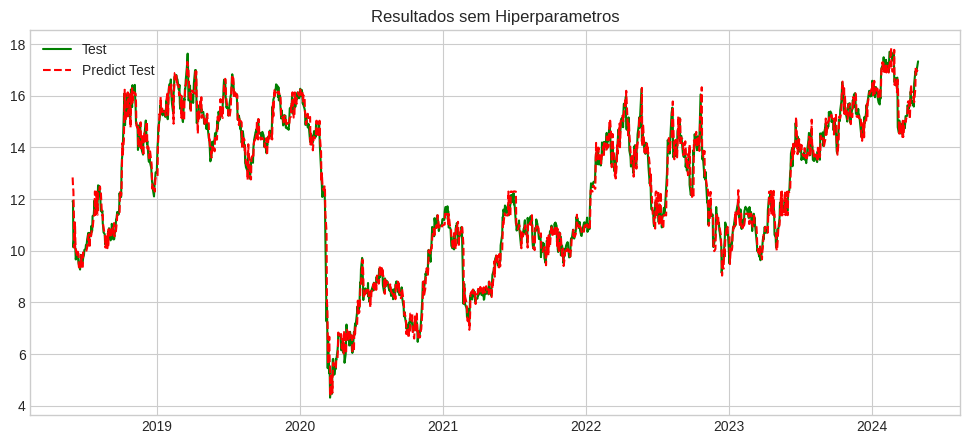

In [77]:
# Vamos plotar os resultados de treinamento e teste
plt.plot(X_test.index, y_test, label='Test', color='green')
plt.plot(X_test.index, y_predict_test, label='Predict Test', color='red', linestyle='--')
plt.legend()
plt.title('Resultados sem Hiperparametros')

Observamos que o modelo se modelou bem á seria temporal, mas podemos avaliar com outras métricas como MSE, MAE e MAPE

In [80]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

MSE = mean_squared_error(y_test, y_predict_test)
MAE = mean_absolute_error(y_test, y_predict_test)
RMSE = mean_squared_error(y_test, y_predict_test, squared=False)
MAPE = mean_absolute_percentage_error(y_test, y_predict_test)

print(f'MSE: {MSE}')
print(f'MAE:{MAE}')
print(f'RMSE: {RMSE}')
print(f'MAPE: {MAPE}')

MSE: 0.16641395659347272
MAE:0.30261360913616764
RMSE: 0.4079386676860539
MAPE: 0.026200720859582433


Vamos analisar os erros obtidos:  
**MAE**: Média absoluta dos erros, basicamente a diferença entre a verdade e o previsto. Foi alcançado um valor de 0.30, ou seja, para uma ação de valor real de RS 5,00, o modelo pode prever de RS 4,70 até RS 5,30.  
**MAPE**: Média Percentual de erro absoluto, ou seja, o erro mensurado em porcentagem. Neste caso foi alcançado 0,026 ou seja 2,6% de erro, um ótimo valor.  
**MSE**: Erro Quadrático Médio, uma métrica que dá um peso maior aos erros maiores, ou seja, sensivel a outliers. Neste caso foi alcançado 0,166.  
**RMSE**: Raiz do Erro Quadrático Médio, a raiz do Erro quadrático médio, apresenta a mesma característica de penalizar erros maiores. Foi alcançado um RMSE de 0,407

Vamos agora utilizar esse modelo, para prever o próximo dia 30-04-2024.  
No nosso caso, utilizamos um lag de 5 (5 dias para prever o futuro), portando precisamos dos ultimos 5 valores previstos para calcular o próximo

Precisamos montar o dataset do forecast na mesma estrutura que o modelo espera, para isso, podemos utilizar o script abaixo.

In [111]:
df_forecast = dataset_reg.copy()

forecast_xgb = df_forecast.index[-1] + np.timedelta64(1, 'D')
X_new = [list(np.flip(df_forecast.close.tail(i).values, axis=0)) + [forecast_xgb.month] + [forecast_xgb.quarter] + [forecast_xgb.weekday()]]
X_new

[[17.33, 17.05, 17.05, 16.81, 16.96, 4, 2, 1]]

In [118]:
from datetime import date, timedelta
forecast_predict = xgb.predict(X_new)
print(f'O valor previsto para a ação no dia {date.today()} é {forecast_predict[0]}')

O valor previsto para a ação no dia 2024-04-30 é 17.154939651489258


### Modelo ARIMA

O modelo arima trabalha com uma série temporal e com 3 principais parametros (p,d,q), onde:
- p: Responsavel pelo número de lag que irá utilizar para prever;
- d: Responsavel pela diferenciação, aplica uma diferenciação nos valores preditos;
- q: Responsavel pela média movel aplicado, por exemplo q=2, aplica uma média móvel com os ultimos 2 valores;

Para um exemplo inicial, iremos utilizar uma order = (2,1,2). Após os resultados, iremos utilizar o Auto arima, para encontrar a melhor configuração para o nosso modelo.

In [199]:
from statsmodels.tsa.arima.model import ARIMA

df_arima = df[['close']]
train_size = int(len(df_arima) * (3/4))

df_train = df_arima[:train_size]
df_train = df_train.resample("D").last()

df_test = df_arima[train_size:]
df_test = df_test.resample("D").last()

modelo_arima = ARIMA(df_train.close, freq='D',order = (2,1,2)).fit()
print(modelo_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 6496
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -8848.639
Date:                Tue, 30 Apr 2024   AIC                          17707.277
Time:                        18:03:34   BIC                          17741.171
Sample:                    08-10-2000   HQIC                         17719.001
                         - 05-23-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2084      0.079     -2.628      0.009      -0.364      -0.053
ar.L2          0.3085      0.100      3.077      0.002       0.112       0.505
ma.L1          0.1765      0.079      2.233      0.0

In [200]:
y_predict_arima = modelo_arima.predict(start=df_test.index.min(), end=df_test.index.max())

In [201]:
# Com o arima podemos analisar a métrica AIC e o erro médio quadrático e sua raiz, utilizando o resid.
MAE_ARIMA = (modelo_arima.resid ** 2).mean()
MAPE_ARIMA = np.sqrt(MAE_ARIMA)

print(f'MAE ARIMA: {MAE_ARIMA}')
print(f'MAPE ARIMA: {MAPE_ARIMA}')

MAE ARIMA: 3.3393270605835097
MAPE ARIMA: 1.8273825709422507


Visualizando os resultados

Text(0.5, 1.0, 'Modelo ARIMA - Resultados')

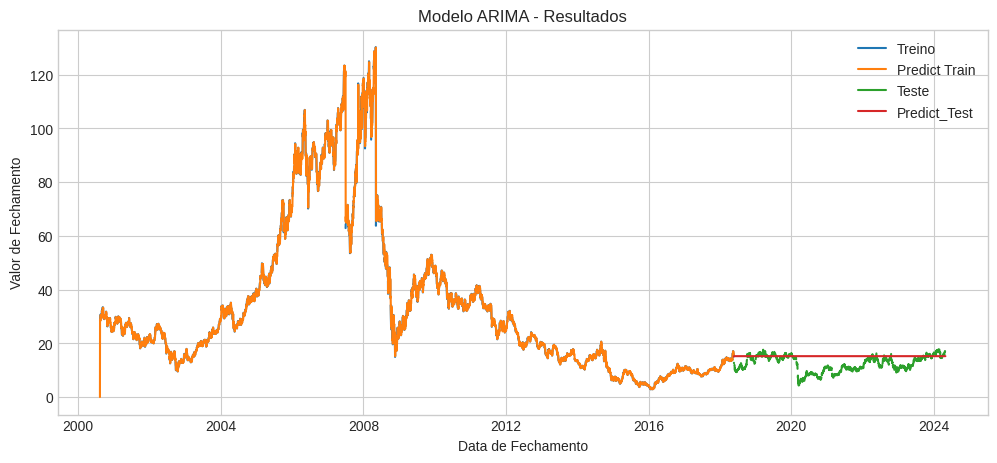

In [202]:
plt.plot(df_train, label='Treino')
plt.plot(modelo_arima.predict(), label = 'Predict Train')
plt.plot(df_test, label='Teste')
plt.plot(y_predict_arima, label='Predict_Test')
plt.xlabel('Data de Fechamento')
plt.ylabel('Valor de Fechamento')
plt.legend()
plt.title('Modelo ARIMA - Resultados')

Observando apenas os resultados de Teste

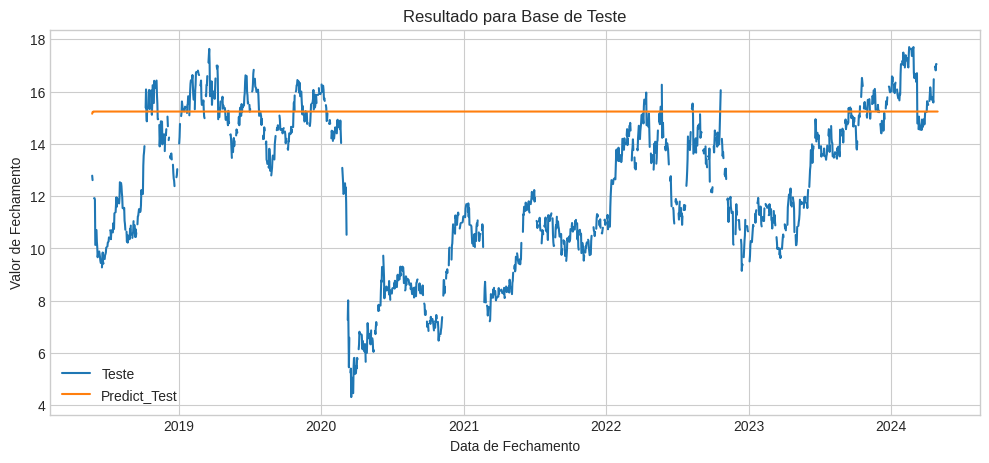

In [203]:
plt.plot(df_test, label='Teste')
plt.plot(y_predict_arima, label='Predict_Test')
plt.xlabel('Data de Fechamento')
plt.ylabel('Valor de Fechamento')
plt.title('Resultado para Base de Teste')
plt.legend()

Com este modelo, podemos prever o valor para o dia 30-04-2024.

In [204]:
# Prevendo o proximo
forecast_t1 = modelo_arima.forecast()[0]

print(f'O valor previsto para a ação para o dia {date.today()} é de :{forecast_t1}')

O valor previsto para a ação para o dia 2024-04-30 é de :15.151274540567167


Agora vamos utilizar o Auto Arima para estimar os melhores valores para p,d,q para o nosso modelo ARIMA e refazer, todos os passos de avaliação e plotagem.

In [175]:
import pmdarima as pm
from pmdarima import model_selection

pm_arima = pm.auto_arima(df_arima,start_p = 0, start_q = 0, d=0, max_p=6, max_q=6 ,seasonal=False,
                         error_action='ignore',stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=60405.688, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=52469.600, Time=0.20 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=22167.432, Time=0.16 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=22166.852, Time=0.99 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=22152.113, Time=0.91 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.21 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=22155.384, Time=0.27 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=22150.554, Time=0.70 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=22151.728, Time=0.40 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=22134.830, Time=1.74 sec
 ARIMA(5,0,2)(0,0,0)[0]             : AIC=22140.910, Time=3.15 sec
 ARIMA(4,0,3)(0,0,0)[0]             : AIC=22171.183, Time=1.79 sec
 ARIMA(3,0,3)(0,0,0)[0]             :

In [205]:
print(f'Melhor Configuração encontrada: {pm_arima}')

Melhor Configuração encontrada:  ARIMA(4,0,4)(0,0,0)[0] intercept


In [206]:
best_model = ARIMA(df_train, freq='D', order=(4,0,4)).fit()

print(best_model.summary())

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 6496
Model:                 ARIMA(4, 0, 4)   Log Likelihood               -8845.083
Date:                Tue, 30 Apr 2024   AIC                          17710.165
Time:                        18:04:15   BIC                          17777.955
Sample:                    08-10-2000   HQIC                         17733.612
                         - 05-23-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         33.6961     36.458      0.924      0.355     -37.760     105.153
ar.L1          0.8871      0.082     10.866      0.000       0.727       1.047
ar.L2          0.2671      0.104      2.559      0.0

In [208]:
# Com o arima podemos analisar a métrica AIC e o erro médio quadrático e sua raiz, utilizando o resid.
y_predict_best_model = best_model.predict(start=df_test.index.min(), end=df_test.index.max())

MAE_ARIMA_BEST = (best_model.resid ** 2).mean()
MAPE_ARIMA_BEST = np.sqrt(MAE_ARIMA_BEST)

print(f'MAE ARIMA: {MAE_ARIMA_BEST}')
print(f'MAPE ARIMA: {MAPE_ARIMA_BEST}')

MAE ARIMA: 3.146388869205037
MAPE ARIMA: 1.7738063223489302


Agora vamos visualizar os resultados obtidos com o modelo ARIMA uitlizando o Auto arima para encontrar os melhores parâmetros.

Text(0.5, 1.0, 'Modelo ARIMA - Resultados')

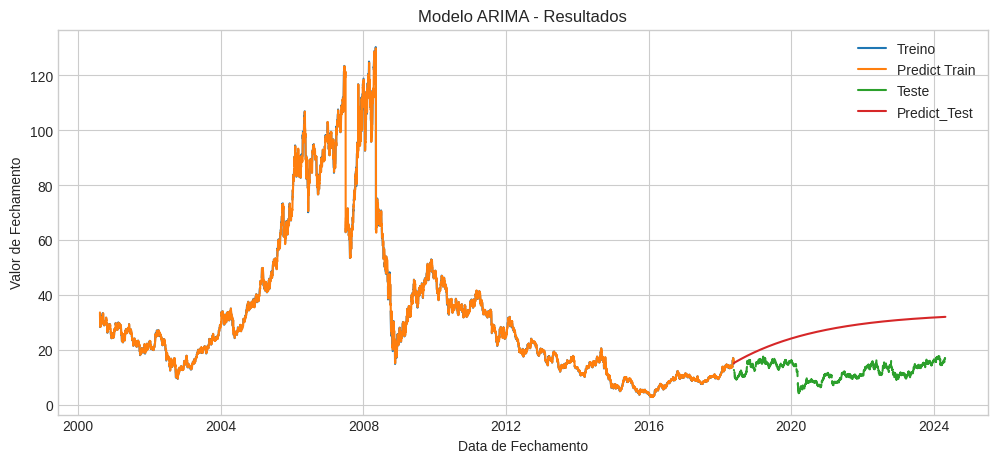

In [209]:
plt.plot(df_train, label='Treino')
plt.plot(best_model.predict(), label = 'Predict Train')
plt.plot(df_test, label='Teste')
plt.plot(y_predict_best_model, label='Predict_Test')
plt.xlabel('Data de Fechamento')
plt.ylabel('Valor de Fechamento')
plt.legend()
plt.title('Modelo ARIMA - Resultados')

E agora prevendo para o dia 30-04-2024

In [210]:
# Prevendo o proximo
forecast_t1_best_model = best_model.forecast()[0]

print(f'O valor previsto para a ação para o dia {date.today()} é de :{forecast_t1_best_model}')

O valor previsto para a ação para o dia 2024-04-30 é de :15.19745970014107


### Resumo dos Resultados

Agora, vamos analisar os erros e os valores previstos para o dia 30-04-2024.

In [217]:
# Apresentando todos os resultados obtidos e os valores previstos para t+1 para futura comparação.

print('Resultados dos MAEs')
print('---'*30)
print(f'MAE XGBOOST: {MAE:.3f}')
print(f'MAE ARIMA:{MAE_ARIMA:.3f}')
print(f'MAE ARIMA TUNING: {MAE_ARIMA_BEST:.3f}')
print('\n')
print('Resultados Previstos')
print('---'*30)
print(f'XGBOOST: {forecast_predict[0]:.3f}')
print(f'ARIMA:{forecast_t1:.3f}')
print(f'ARIMA TUNING: {forecast_t1_best_model:.3f}')

Resultados dos MAEs
------------------------------------------------------------------------------------------
MAE XGBOOST: 0.303
MAE ARIMA:3.339
MAE ARIMA TUNING: 3.146


Resultados Previstos
------------------------------------------------------------------------------------------
XGBOOST: 17.155
ARIMA:15.151
ARIMA TUNING: 15.197


In [7]:
print(f'Valor Real para o dia 30-05-2024 : {df.close.tail(1).values}')

Valor Real para o dia 30-05-2024 : [16.97]


Hoje, dia 01-05-2024, consultando a nossa API para o valor da ação no fechamento do dia 30-04-2024, encontramos o valor de R\$ 16,97.  

Comparando com as nossas previsões:  
XGBRegressor -> Previsto: R\$`17.15`  |  Real: R\$`16,97`   | Erro: `1,06%`  
ARIMA S/Turn -> Previsto: R\$`15.15`  |  Real: R\$`16,97`   | Erro: `10,7%`  
ARIMA C/Turn -> Previsto: R\$`15.19`  |  Real: R\$`16,97`   | Erro: `10,4%`  
